In [1]:
# Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create a Spark Session
spark = SparkSession.builder.appName("LOGISTIC").getOrCreate()

In [3]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('weather_august.csv')
# Create a Pandas Dataframe
aug_df = spark.createDataFrame(df)
# Convert the PySpark DataFrame to a Pandas DataFrame
aug_df_pd = aug_df.toPandas()

In [4]:
# Transform 'Precipitation' column into qualitative variable
aug_df_pd['Precipitation'] = df['Precipitation'].apply(lambda x: 1 if x > 0 else 0)

# Show the Dataframe
aug_df_pd.head()

,Precipitation,Global_Radiation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed
0,0,0.1,929.30,12.15,12.10,100.0,2.70
1,0,5.0,929.75,12.35,12.35,100.0,2.45
2,0,135.8,930.20,12.55,12.55,100.0,2.50
3,0,488.0,930.40,13.35,13.35,100.0,2.90
4,0,1631.1,930.60,15.50,13.65,89.5,3.05


In [5]:
# Table of absolute frequencies of the 'Precipitation' variable

aug_df_pd['Precipitation'].value_counts()

0    349
1     26
Name: Precipitation, dtype: int64

In [6]:
import seaborn as sns 
import statsmodels.api as sm 
import numpy as np 
from scipy import stats
from statsmodels.iolib.summary2 import summary_col 
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Estimation of a binary logistic model
prec_model = smf.glm(formula='Precipitation ~  Avarage_Temperature +\
                                Global_Radiation +\
                                Avarage_Atmospheric_Pressure +\
                                Avarage_Dew_Temperature +\
                                Avarage_Relative_Humidity +\
                                Avarage_Wind_Speed', data=aug_df_pd,
                         family=sm.families.Binomial()).fit()

# Model parameters
prec_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Precipitation   No. Observations:                  375
Model:                            GLM   Df Residuals:                      368
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -67.886
Date:                Fri, 22 Sep 2023   Deviance:                       135.77
Time:                        13:46:19   Pearson chi2:                     327.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1322
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      114.8962     88.992      1.291      0.197     -59.525     289.318
Avarage_Temperature             -0.2870      1.010     -0.284      0.776      -2.266       1.692
Global_Radiation                 0.0006      0.001      1.025      0.306      -0.001       0.002
Avarage_Atmospheric_Pressure    -0.1333      0.087     -1.533      0.125      -0.304       0.037
Avarage_Dew_Temperature         -0.0241      0.997     -0.024      0.981      -1.977       1.929
Avarage_Relative_Humidity        0.1059      0.197      0.539      0.590      -0.279       0.491
Avarage_Wind_Speed               0.2807      0.137      2.042      0.041       0.011       0.550
================================================================================================
"""

In [8]:
# Model outputs through the 'summary_col' function
summary_col([prec_model],
            model_names=["MODEL"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODEL
Intercept,114.8962
,(88.9922)
Avarage_Temperature,-0.2870
,(1.0098)
Global_Radiation,0.0006
,(0.0006)
Avarage_Atmospheric_Pressure,-0.1333
,(0.0869)
Avarage_Dew_Temperature,-0.0241
,(0.9967)


In [9]:
# Making predictions for the 'prec_model'.
prec_model.predict(pd.DataFrame({'Avarage_Temperature':[12.15],
                                'Global_Radiation':[0.1],
                                'Avarage_Atmospheric_Pressure':[929.3],
                                'Avarage_Dew_Temperature':[12.1],
                                'Avarage_Relative_Humidity':[100.0],
                                'Avarage_Wind_Speed':[2.7]}))

0    0.199507
dtype: float64

In [10]:
# Construction of a confusion matrix

# Adding predicted probability values ​​to the database
aug_df_pd['phat'] = prec_model.predict()

# Viewing the database with the 'phat' variable
aug_df_pd.head()

,Precipitation,Global_Radiation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed,phat
0,0,0.1,929.30,12.15,12.10,100.0,2.70,0.199507
1,0,5.0,929.75,12.35,12.35,100.0,2.45,0.170808
2,0,135.8,930.20,12.55,12.55,100.0,2.50,0.166958
3,0,488.0,930.40,13.35,13.35,100.0,2.90,0.174627
4,0,1631.1,930.60,15.50,13.65,89.5,3.05,0.071188


In [11]:
# Construction of function to define the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observed, cutoff):
    
    values = predicts.values
    
    binary_prediction = []
        
    for item in values:
        if item < cutoff:
            binary_prediction.append(0)
        else:
            binary_prediction.append(1)
           
    cm = confusion_matrix(binary_prediction, observed)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitivity = recall_score(observed, binary_prediction, pos_label=1)
    specificity = recall_score(observed, binary_prediction, pos_label=0)
    accuracy = accuracy_score(observed, binary_prediction)

    # Visualizing the main indicators of this confusion matrix
    indicators = pd.DataFrame({'Sensitivity':[sensitivity],
                                'Specificity':[specificity],
                                'Accuracy':[accuracy]})
    return indicators

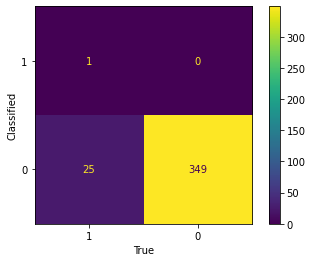

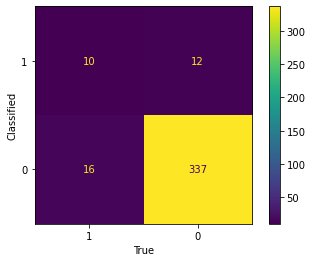

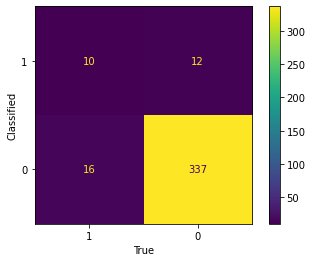

,Sensitivity,Specificity,Accuracy
0,0.384615,0.965616,0.925333


In [12]:
# Confusion matrices proper

# Confusion matrix for cutoff = 0.5
matriz_confusao(observed=aug_df_pd['Precipitation'],
                predicts=aug_df_pd['phat'], 
                cutoff=0.5)

# Confusion matrix for cutoff = 0.3
matriz_confusao(observed=aug_df_pd['Precipitation'],
                predicts=aug_df_pd['phat'], 
                cutoff=0.3)

# Confusion matrix for cutoff = 0.7
matriz_confusao(observed=aug_df_pd['Precipitation'],
                predicts=aug_df_pd['phat'], 
                cutoff=0.3)

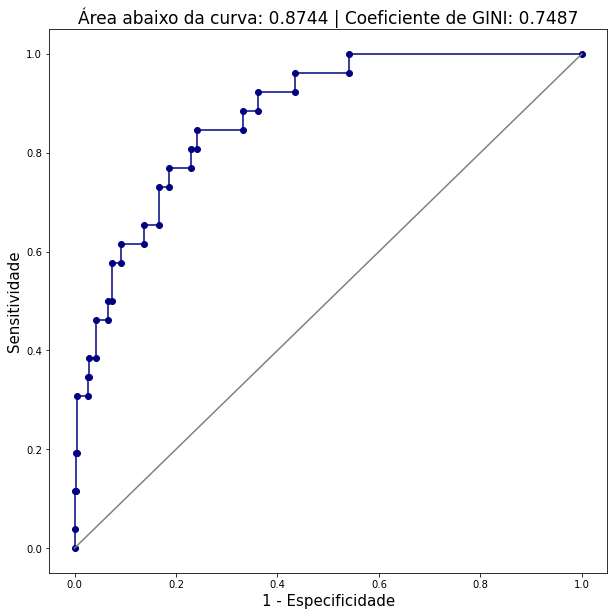

In [13]:
# Construction of the ROC curve
from sklearn.metrics import roc_curve, auc

# 'roc_curve' function from sklearn's 'metrics' package
fpr, tpr, thresholds =roc_curve(aug_df_pd['Precipitation'],aug_df_pd['phat'])
roc_auc = auc(fpr, tpr)

# Calculation of the GINI coefficient
gini = (roc_auc - 0.5)/(0.5)

# Plotting the ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr, '-o', color='navy')
plt.plot(fpr,fpr, color='gray')
plt.title('Área abaixo da curva: %g' % roc_auc.round(4) +
          ' | Coeficiente de GINI: %g' % gini.round(4), fontsize=17)
plt.xlabel('1 - Especificidade', fontsize=15)
plt.ylabel('Sensitividade', fontsize=15)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

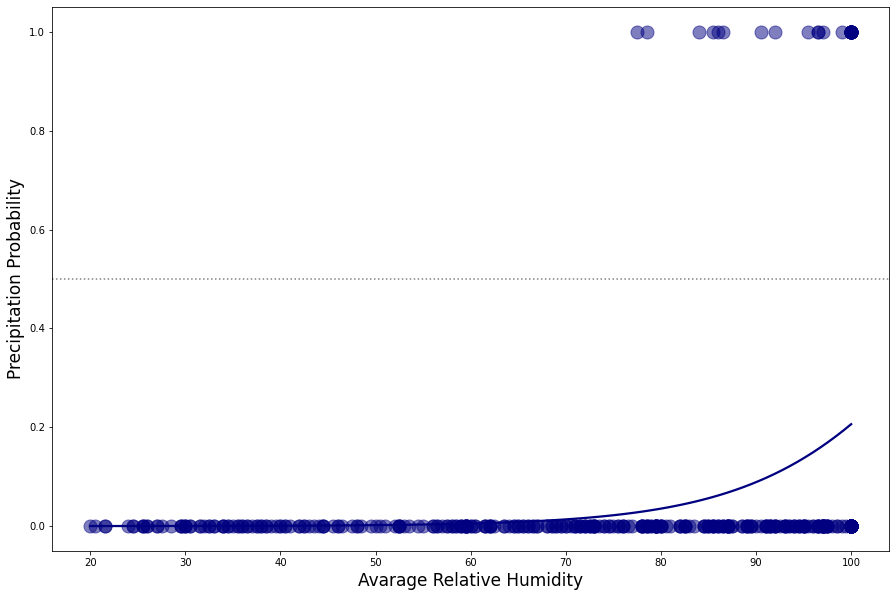

In [14]:
# Construction of the sigmoid
# Probability of event depending on the variable 'Avarage_Relative_Humidity', for example

plt.figure(figsize=(15,10))
sns.regplot(x=aug_df_pd['Avarage_Relative_Humidity'], y=aug_df_pd['Precipitation'],
            data=aug_df_pd, logistic=True, ci=None, color='navy',
            marker='o', scatter_kws={'color':'navy', 'alpha':0.5, 's':170})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Avarage Relative Humidity', fontsize=17)
plt.ylabel('Precipitation Probability', fontsize=17)
plt.show